# Developement of optimization algorithm

In optimization_developement.ipynb I build a relatively simplemodel which can take different parameters as input and thus can be easily changed.

The next aim is developing an algorithm to find a good model. The difference compared to classical fitting is that the no constant truth which is fit, thus standard implementations of the usual algorithms do not work. 

First all needed libraries and own functions are imported.

In [1]:
import numpy as np
import random as random
import scipy
#using simpleguitk for display, is not needed for computer game
import simpleguitk as simplegui
import time
#new ones
import pandas as pd
#ml methods
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import os
#skyjo game classes and functions 
from skyjo_functions4 import *
#own functions for machine learning
from ml_functions2 import *
#for plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix
#for saving and loading of stranger object
import pickle

Any fit needs to start with with at least one mdoel to play against. This very first is when all parameters are 0. 
Asd the next step I try a change only one parameter at a time the first step to a gradient based algorithm.
It has input the step sizes for all parameters and the number of relaizations the model is run. 

In [2]:
#means changes within the function do not have an effect outside of it , copy it to the top functions does not change anything 
def first_gradient_step(open_steps,discard_steps,value_steps,realizations):
    n_it=realizations
    results=np.zeros((40,19))
    for j in range(results.shape[1]):
        print(f"doing case {j}")
        level20_open_variable=np.zeros((6))
        level20_discard_variable=np.zeros((6))
        level20_value_variable=np.zeros((7))
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        if j<6:
            level21_open_variable[j]=open_steps[j]
        elif j<12:
            level21_discard_variable[j-6]=discard_steps[j-6]
        else:
            level21_value_variable[j-12]=value_steps[j-12]    
        print(level21_open_variable,level21_discard_variable,level21_value_variable)
        results[0:6,j]=level20_open_variable
        results[6:12,j]=level20_discard_variable
        results[12:19,j]=level20_value_variable    
        results[19:25,j]=level21_open_variable
        results[25:31,j]=level21_discard_variable
        results[31:38,j]=level21_value_variable         
        win20=0
        start_time=time.time()
        for i in range(n_it):
            names=['alpha','beta']
            nature=['computer','computer']
            levels=[20,21]
            winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
            if winner[0]==1:
                win20+=1
        results[38,j]=n_it
        results[39,j]=win20
        stop_time=time.time()
        print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
        print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
    return results     

I run it several times, with the aims of finding which parameter size matters for winning, since it is clear that it will saturate at some point since the range of outcomes is limited. 

In [27]:
factors=[-0.00005,-0.0001,-0.0002,-0.0005,-0.001,-0.002,-0.005,-0.01,-0.02,-0.05,-0.1]
for i in range(len(factors)):
    print(f"doing factor {factors[i]}")
    open_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    discard_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    value_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    #does not recreated levls good 
    result=first_gradient_step(open_step,discard_step,value_step,400)
    #outcommented that it is not overwritten by chance
    #np.savetxt("gradient_level20_vm"+str(i)+".txt",result)

doing factor -5e-05
doing case 0
[-5.e-05  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.707 seconds
level 20 won to 45.0 %
doing case 1
[ 0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.628 seconds
level 20 won to 50.0 %
doing case 2
[ 0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.47 seconds
level 20 won to 49.0 %
doing case 3
[ 0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.62 seconds
level 20 won to 50.5 %
doing case 4
[ 0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.127 seconds
level 20 won to 48.2 %
doing case 5
[ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.84 seconds
level 20 won to 49.0 %
doing case 6
[0. 0. 0. 0. 0. 

400 games need 22.451 seconds
level 20 won to 52.2 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.     -0.0002  0.      0.      0.      0.      0.    ]
400 games need 21.956 seconds
level 20 won to 48.2 %
doing case 14
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.     -0.0002  0.      0.      0.      0.    ]
400 games need 21.796 seconds
level 20 won to 49.5 %
doing case 15
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.     -0.0002  0.      0.      0.    ]
400 games need 21.297 seconds
level 20 won to 61.2 %
doing case 16
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.     -0.0002  0.      0.    ]
400 games need 21.807 seconds
level 20 won to 50.5 %
doing case 17
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.     -0.0002  0.    ]
400 games need 20.862 seconds
level 20 won to 57.5 %
doing case 18
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.      0.     -0.0002]
400 games 

400 games need 24.202 seconds
level 20 won to 49.8 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.     0.    -0.002  0.     0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.193 seconds
level 20 won to 41.5 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.    -0.002  0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.484 seconds
level 20 won to 15.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.    -0.002  0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.745 seconds
level 20 won to 41.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.     0.    -0.002] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.914 seconds
level 20 won to 16.5 %
doing case 12
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [-0.002  0.     0.     0.     0.     0.     0.   ]
400 games need 21.812 seconds
level 20 won to 53.0 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.    -0.002  0.     0.     0.     0.     0.   ]
400 games need 20.24 seconds
level 20 won to 67.8 %
doing case 14
[0. 

400 games need 25.533 seconds
level 20 won to 41.0 %
doing case 5
[ 0.    0.    0.    0.    0.   -0.02] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.576 seconds
level 20 won to 38.5 %
doing case 6
[0. 0. 0. 0. 0. 0.] [-0.02  0.    0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.114 seconds
level 20 won to 30.0 %
doing case 7
[0. 0. 0. 0. 0. 0.] [ 0.   -0.02  0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.617 seconds
level 20 won to 32.2 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.    0.   -0.02  0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.844 seconds
level 20 won to 18.2 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.   -0.02  0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.598 seconds
level 20 won to 13.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.   -0.02  0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.52 seconds
level 20 won to 19.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.    0.   

Running that time, that needs to be considered, that a fit does not take too long. Also since there is not a fully defined truth it is less important to be very good against a model, since it is more important to be good overall since a very good performance against a model could be just a good solution agianst this but not in general. 

Now I am loading all positive factors file and combine them in a file for plotting to find where the gradient flattens for the different parameters.

In [4]:
gra1=np.loadtxt("gradient_level20_v1.txt")
gra2=np.loadtxt("gradient_level20_v2.txt")
gra3=np.loadtxt("gradient_level20_v3.txt")
gra4=np.loadtxt("gradient_level20_v4.txt")
gra5=np.loadtxt("gradient_level20_v5.txt")
gra6=np.loadtxt("gradient_level20_v6.txt")
gra7=np.loadtxt("gradient_level20_v7.txt")
gra8=np.loadtxt("gradient_level20_v8.txt")
gra9=np.loadtxt("gradient_level20_v9.txt")
gra10=np.loadtxt("gradient_level20_v10.txt")
gra11=np.loadtxt("gradient_level20_v11.txt")
gra12=np.loadtxt("gradient_level20_v12.txt")
gra13=np.loadtxt("gradient_level20_v13.txt")
gra14=np.loadtxt("gradient_level20_v14.txt")
compp=np.zeros((20,14))
compp[0,:]=np.array([1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001,0.00005])
compp[1:20,0]=gra1[39,:]/gra1[38,:]
compp[1:20,1]=gra2[39,:]/gra2[38,:]
compp[1:20,2]=gra3[39,:]/gra3[38,:]
compp[1:20,3]=gra4[39,:]/gra4[38,:]
compp[1:20,4]=gra5[39,:]/gra5[38,:]
compp[1:20,5]=gra6[39,:]/gra6[38,:]
compp[1:20,6]=gra7[39,:]/gra7[38,:]
compp[1:20,7]=gra8[39,:]/gra8[38,:]
compp[1:20,8]=gra9[39,:]/gra9[38,:]
compp[1:20,9]=gra10[39,:]/gra10[38,:]
compp[1:20,10]=gra11[39,:]/gra11[38,:]
compp[1:20,11]=gra12[39,:]/gra12[38,:]
compp[1:20,12]=gra13[39,:]/gra13[38,:]
compp[1:20,13]=gra14[39,:]/gra14[38,:]

Now I plot them, separately for three different actions which take parameters. Starting with the parameters for action of taking open pile card or not.

Text(0.5, 1.0, 'taking open pile card')

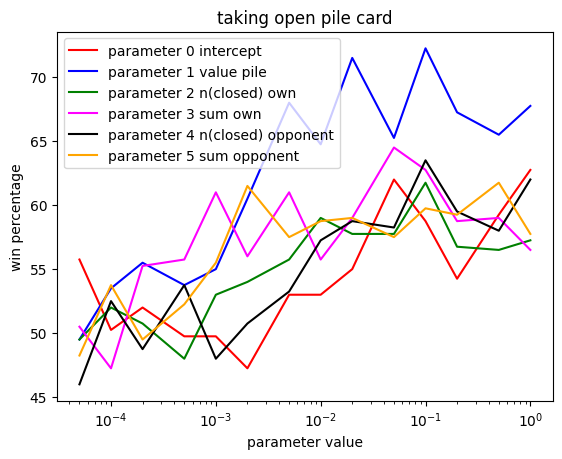

In [9]:
plt.plot(compp[0,:],100*compp[1,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[2,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[3,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[4,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[5,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[6,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("taking open pile card")

No action gets very large percentages here, but as expected the value of the open card matters most.

Text(0.5, 1.0, 'discarding closed pile card')

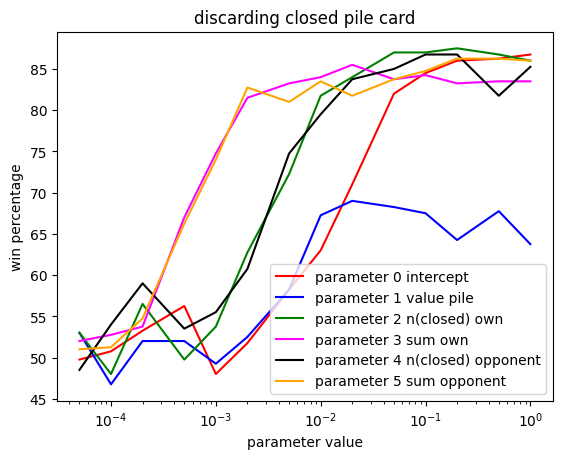

In [10]:
plt.plot(compp[0,:],100*compp[7,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[8,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[9,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[10,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[11,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[12,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("discarding closed pile card")

Here the parameter more, since that is more related to finishing games first or second. In a random strategy finishing second is better since otherwise the score can be doubled when it is higher than the oppoenents. 
Sum matters for smaller paremeters because its numbers are smaller than for the number of closed cards and the values of cards. 

Text(0.5, 1.0, 'playing closed or maximum value')

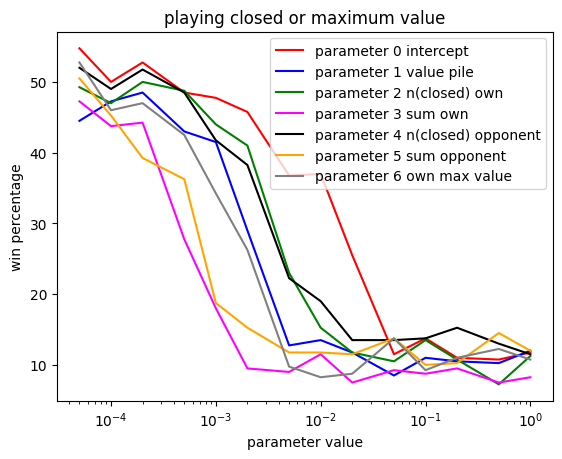

In [11]:
plt.plot(compp[0,:],100*compp[13,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[14,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[15,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[16,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[17,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[18,:],color='orange',label='parameter 5 sum opponent') 
plt.plot(compp[0,:],100*compp[19,:],color='gray',label='parameter 6 own max value') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("playing closed or maximum value")

Similar as before, after the sum also the value of the maximum cards matters for the decision relatively much. 

It flattened always at most at 0.1.

Now the same for negative values of parameters. First collecting the values. 

In [7]:
gram1=np.loadtxt("gradient_level20_vm0.txt")
gram2=np.loadtxt("gradient_level20_vm1.txt")
gram3=np.loadtxt("gradient_level20_vm2.txt")
gram4=np.loadtxt("gradient_level20_vm3.txt")
gram5=np.loadtxt("gradient_level20_vm4.txt")
gram6=np.loadtxt("gradient_level20_vm5.txt")
gram7=np.loadtxt("gradient_level20_vm6.txt")
gram8=np.loadtxt("gradient_level20_vm7.txt")
gram9=np.loadtxt("gradient_level20_vm8.txt")
gram10=np.loadtxt("gradient_level20_vm9.txt")
gram11=np.loadtxt("gradient_level20_vm10.txt")
compm=np.zeros((20,11))
compm[0,:]=np.array([0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1])
compm[1:20,0]=gram1[39,:]/gram1[38,:]
compm[1:20,1]=gram2[39,:]/gram2[38,:]
compm[1:20,2]=gram3[39,:]/gram3[38,:]
compm[1:20,3]=gram4[39,:]/gram4[38,:]
compm[1:20,4]=gram5[39,:]/gram5[38,:]
compm[1:20,5]=gram6[39,:]/gram6[38,:]
compm[1:20,6]=gram7[39,:]/gram7[38,:]
compm[1:20,7]=gram8[39,:]/gram8[38,:]
compm[1:20,8]=gram9[39,:]/gram9[38,:]
compm[1:20,9]=gram10[39,:]/gram10[38,:]
compm[1:20,10]=gram11[39,:]/gram11[38,:]

Text(0.5, 1.0, 'taking open card')

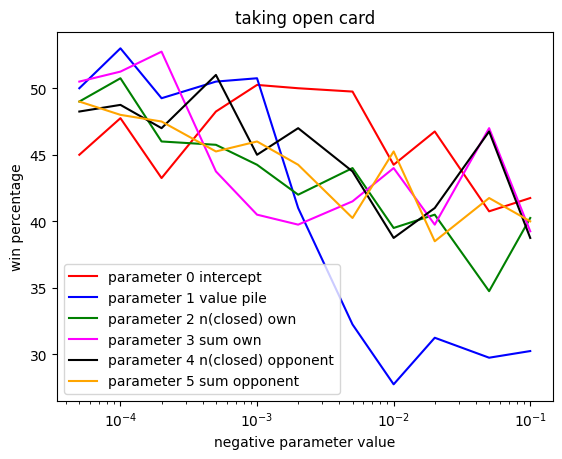

In [8]:
plt.plot(compm[0,:],100*compm[1,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[2,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[3,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[4,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[5,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[6,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("negative parameter value")
plt.ylabel("win percentage")
plt.title("taking open pile card")

As expected it is mostly the reverse of taking positive actions. Most deviations of it are likely chance. The same is visible below

Text(0.5, 1.0, 'discarding closed pile card')

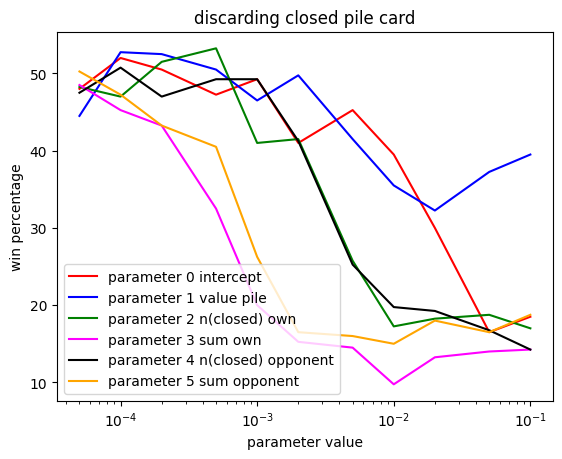

In [12]:

plt.plot(compm[0,:],100*compm[7,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[8,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[9,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[10,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[11,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[12,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("discarding closed pile card")

Text(0.5, 1.0, 'playing closed or maximum value')

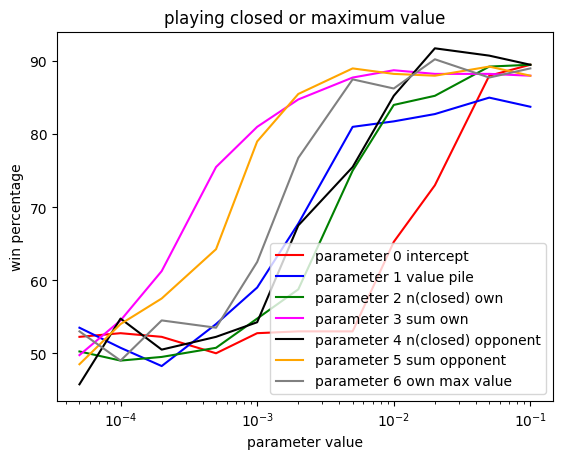

In [13]:
plt.plot(compm[0,:],100*compm[13,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[14,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[15,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[16,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[17,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[18,:],color='orange',label='parameter 5 sum opponent') 
plt.plot(compm[0,:],100*compm[19,:],color='gray',label='parameter 6 own max value') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("playing closed or maximum value")

As another exploring attenpt, I now constract a Monte Carlo procedure.
As the first step I create the function montecarlo_trials.
It takes lists of several model parameters as input. These are the levels 20. It plays against those by creating Monte Cralo model, the levels 21. They  are created randomly with given ranges. It creates a given number of of Monte Cralo trails, each with the same number of game realizations. 

In [14]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
def montecarlo_trials(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials):
    n_it=realizations
    results=np.zeros((40,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            print(np.round(level21_open_variable,5),np.round(level21_discard_variable,5),np.round(level21_value_variable,5))
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            start_time=time.time()
            for i in range(n_it):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            results[38,j,k]=n_it
            results[39,j,k]=win20
            stop_time=time.time()
            print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[39,j,:])*100/n_it,1)} %")   
    return results 

Now  I am testing the function.

In [66]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0))]
list_discard=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0))]
list_value=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0))]


res=montecarlo_trials(list_open,list_discard,list_value,op_range,dis_range,val_range,50,4)
np.save("mc_v3.npy",res)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467]
50 games need 1.344 seconds
level 20 won to 94.0 %
trying case 1 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467]
50 games need 1.378 seconds
level 20 won to 96.0 %
trying case 2 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467]
50 games need 1.519 seconds
level 20 won to 92.0 %
trying case 3 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467

In [ ]:
Below I plot an example. 

Text(0, 0.5, 'level 20 wins [%]')

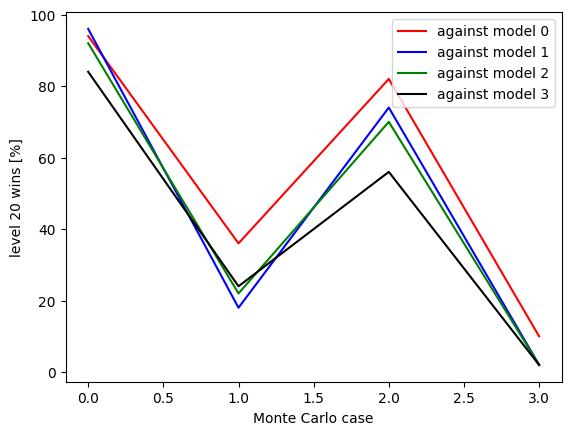

In [110]:
res3=np.load("mc_v2.npy")
plt.plot(range(4),res3[39,:,0]/res3[38,:,0]*100,color='red',label='against model 0') 
plt.plot(range(4),res3[39,:,1]/res3[38,:,0]*100,color='blue',label='against model 1') 
plt.plot(range(4),res3[39,:,2]/res3[38,:,0]*100,color='green',label='against model 2') 
plt.plot(range(4),res3[39,:,3]/res3[38,:,0]*100,color='black',label='against model 3') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("level 20 wins [%]")

Rather easy to improve compared to the current models. Below I print the results for human trial. 

In [17]:
print(res[19:25,3,2])
print(res[25:31,3,2])
print(res[31:38,3,2])

[ 0.01940094  0.05146526 -0.02648223 -0.07416882 -0.00188127 -0.01222425]
[ 0.07948311  0.05037697  0.00790461 -0.03574202  0.01697387 -0.05714196]
[-0.05759114  0.07014045 -0.05425065  0.09631128 -0.06878424 -0.00164203
  0.08420359]


As another test I include this model in the list of input models. It should clearly harder to win against this one. 

In [18]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open2=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0)),res3[19:25,3,2]]
list_discard2=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0)),res3[25:31,3,2]]
list_value2=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0)),res3[31:38,3,2]]

res2=montecarlo_trials(list_open2,list_discard2,list_value2,op_range,dis_range,val_range,50,5)
np.save("mc_v6.npy",res2)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 3.768 seconds
level 20 won to 38.0 %
trying case 1 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 2.397 seconds
level 20 won to 4.0 %
trying case 2 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 2.451 seconds
level 20 won to 24.0 %
trying case 3 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]

Text(0, 0.5, 'level 20 wins [%]')

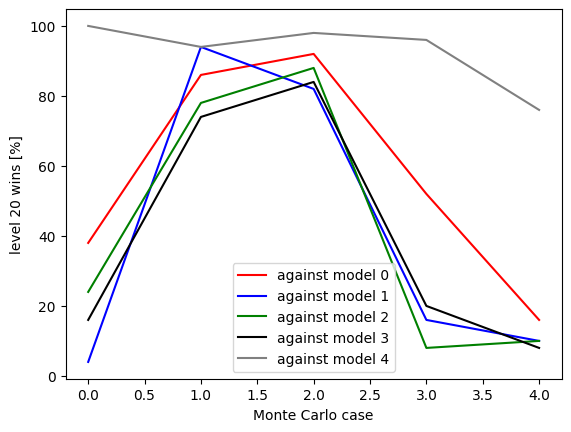

In [25]:
res2=np.load("mc_v6.npy")
plt.plot(range(5),res2[39,:,0]/res2[38,:,0]*100,color='red',label='against model 0') 
plt.plot(range(5),res2[39,:,1]/res2[38,:,0]*100,color='blue',label='against model 1') 
plt.plot(range(5),res2[39,:,2]/res2[38,:,0]*100,color='green',label='against model 2') 
plt.plot(range(5),res2[39,:,3]/res2[38,:,0]*100,color='black',label='against model 3') 
plt.plot(range(5),res2[39,:,4]/res2[38,:,0]*100,color='gray',label='against model 4')
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("level 20 wins [%]")

As expected the latest model performs clearly better than the other models. 

Now I am changing the function somewhat to make it faster by stopping it early when either a good model is found 
or a Monte Carlo realization is clearly (not) an improvement. Below I first calculate how iterations are at least needed, that a test something is bad fit can make sense. 

In [64]:
x=100
sig=(0-x/2)/np.sqrt(x)
print(sig)
#sig**2=(x**2)/4/x
#sig**2=x/4
sig2=2.33
x2=(sig2**2)*4
print(x2)


-5.0
21.715600000000002


In [90]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
#wfrac when it aborts early 
def montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=0.10):
    n_it=realizations
    results=np.zeros((41,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            it_counter=0
            start_time=time.time()
            n_it1=n_it
            if n_it1>22:
                n_it1=22
            #22 always     
            for i in range(n_it1):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            #99% ownside win conditions tested here   2.33 sigma   stops early when new model bad 
            while it_counter<n_it and abs((win20-it_counter/2)/np.sqrt(it_counter))<2.33:  
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1                
            #now checking whether 98% sigficant on bad performance        
            results[38,j,k]=it_counter
            results[39,j,k]=win20
            results[40,j,k]=100*win20/it_counter         
            stop_time=time.time()
            print(f"{it_counter} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(results[40,j,k],1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[40,j,:]),1)} %") 
        if np.mean(results[39,j,:])/n_it<wfrac:
            print("early stopping model found, aborts early")
            if j==0:
                return results[:,j,:]
            else:
                return results[:,0:j,:]
    print("no early stopping model found")    
    return results 

In [107]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0))]
list_discard=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0))]
list_value=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0))]

start_time=time.time()
res=montecarlo_trials2(list_open,list_discard,list_value,op_range,dis_range,val_range,50,4,wfrac=0.01)
np.save("mc_v7.npy",res)
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")

doing Monte Carlo 0 for level 21
trying case 0 for level 20
50 games need 3.916 seconds
level 20 won to 32.0 %
trying case 1 for level 20
36 games need 1.802 seconds
level 20 won to 11.1 %
trying case 2 for level 20
46 games need 1.999 seconds
level 20 won to 15.2 %
trying case 3 for level 20
30 games need 1.235 seconds
level 20 won to 6.7 %
level 20 won in average to 16.2 %
doing Monte Carlo 1 for level 21
trying case 0 for level 20
26 games need 1.047 seconds
level 20 won to 96.2 %
trying case 1 for level 20
50 games need 1.966 seconds
level 20 won to 82.0 %
trying case 2 for level 20
50 games need 2.072 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 1.701 seconds
level 20 won to 74.0 %
level 20 won in average to 79.0 %
doing Monte Carlo 2 for level 21
trying case 0 for level 20
22 games need 1.087 seconds
level 20 won to 100.0 %
trying case 1 for level 20
46 games need 1.563 seconds
level 20 won to 84.8 %
trying case 2 for level 20
50 games need 1.716 second

Below testing the output. 

In [89]:
print(res[38:41,:,:].T)

[[[ 50.          26.          52.        ]
  [ 50.          22.          44.        ]
  [ 50.          15.          30.        ]
  [ 33.          30.          90.90909091]]

 [[ 50.           6.          12.        ]
  [ 50.          10.          20.        ]
  [ 50.           6.          12.        ]
  [ 50.          41.          82.        ]]

 [[ 50.           2.           4.        ]
  [ 50.          12.          24.        ]
  [ 50.           3.           6.        ]
  [ 50.          38.          76.        ]]

 [[ 50.           1.           2.        ]
  [ 50.          15.          30.        ]
  [ 50.           8.          16.        ]
  [ 50.          23.          46.        ]]

 [[ 22.          22.         100.        ]
  [ 50.           6.          12.        ]
  [ 50.          38.          76.        ]
  [ 33.          30.          90.90909091]]]


In [88]:
Now I am building the Monte Carlo fiiting function. 

[]


In [119]:

def montecarlo_fit(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations=50,trials=10,wfrac=0.10,max_iter=10,wfrac2=0.5):
    #list to performances of winner models
    listres=[]
    for i in range(max_iter):
        print(f"iteration {i} using {len(open_vars)} level 20 models")
        res=montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=wfrac)
        #appending of good enough models
        #if only one just append it
        if res.ndim==2:
            #append this model
            open_vars.append(res[19:25,0])
            discard_vars.append(res[25:31,0])
            value_vars.append(res[31:38,0])
            print("model to append found")
            print(f"best model won to {np.round(100-np.mean(res[40,:]),1)} %")
            listres.append(res)
        else:
            #get average over different level 20
            av_wins=np.mean(res[40,:,:],1)
            best=np.argmin(av_wins)
            #append if good
            if min(av_wins/100)<wfrac2:
                open_vars.append(res[19:25,best,0])
                discard_vars.append(res[25:31,best,0])
                value_vars.append(res[31:38,best,0])
                listres.append(res[:,best,:])
                print("model to append found")
                print(f"best model won to {np.round(100-np.mean(res[40,best,:]),1)} %")
            else:  
                #stops early when no goof enough model is found
                print(f"best model won to {np.round(100-np.mean(res[40,best,:]),1)} %")       
                print("no model to append found fit stopped early")
                #should save somewhat different usual format files, they need to be converted anyway for using it
                return open_vars, discard_vars, value_vars,listres 
    print("all iterations done")            
    return open_vars, discard_vars, value_vars,listres     

In [118]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open2=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0)),res3[19:25,3,2]]
list_discard2=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0)),res3[25:31,3,2]]
list_value2=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0)),res3[31:38,3,2]]


start_time=time.time()
list_open3,list_discard3,list_value3,list_res3=montecarlo_fit(list_open2,list_discard2,list_value2,op_range,dis_range,val_range,realizations=50,trials=20,wfrac=0.4,max_iter=8,wfrac2=0.55)
with open('mc_v1_list_res.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(list_res3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v1_list_open.pkl', 'wb') as f:
    pickle.dump(list_open3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v1_list_discard.pkl', 'wb') as f:
    pickle.dump(list_discard3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v1_list_value.pkl', 'wb') as f:
    pickle.dump(list_value3, f, pickle.HIGHEST_PROTOCOL)    
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")

iteration 0 using 5 level 20 models
doing Monte Carlo 0 for level 21
trying case 0 for level 20
30 games need 2.451 seconds
level 20 won to 6.7 %
trying case 1 for level 20
22 games need 1.454 seconds
level 20 won to 0.0 %
trying case 2 for level 20
26 games need 1.301 seconds
level 20 won to 3.8 %
trying case 3 for level 20
22 games need 1.019 seconds
level 20 won to 0.0 %
trying case 4 for level 20
50 games need 15.763 seconds
level 20 won to 74.0 %
level 20 won in average to 16.9 %
early stopping model found, aborts early
(41, 5)
model to append found
best model won to 83.1 %
iteration 1 using 6 level 20 models
doing Monte Carlo 0 for level 21
trying case 0 for level 20
43 games need 1.29 seconds
level 20 won to 86.0 %
trying case 1 for level 20
43 games need 1.26 seconds
level 20 won to 86.0 %
trying case 2 for level 20
50 games need 1.463 seconds
level 20 won to 50.0 %
trying case 3 for level 20
50 games need 1.436 seconds
level 20 won to 58.0 %
trying case 4 for level 20
22 games

In [115]:
with open('mc_v1_list_res.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_res3b = pickle.load(f)

In [116]:
print(list_res3b)

[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.00000000e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.00000000e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
     

Wokrs svaing this way, but would be betetr to create a format which already combines the list into an np.array. 